# Model the drizzled JWST image.

Perform this notebook requires standard astroconda libraries and the publicly available packages on github.

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
- fastell4py (only when using the SPEMD model) (https://github.com/sibirrer/fastell4py), based on the original fastell fortran code (by Barkana)

This notebook has been tested with on Python 3.6.10, lenstronomy 1.3.0.

### Note that this notebook models the drizzled simulated image.


In [1]:
# import the necessary python modules

import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import glob
#from gen_fit_id import gen_fit_id
from photutils import make_source_mask
import os

import sys
sys.path.insert(0,'../../../py_tools/')
from fit_qso import fit_qso
from transfer_to_result import transfer_to_result
from mask_objects import detect_obj
from flux_profile import profiles_compare, flux_profile
from matplotlib.colors import LogNorm
import copy
import time
import pickle

In [2]:
#Setting the fitting condition:
deep_seed = True  #Set as True to put more seed and steps to fit.
pltshow = 1 #Note that setting plt.ion() in line27, the plot won't show anymore if running in terminal.
pix_scale = 0.04 
fixcenter = False
run_MCMC = False
zp= 28.

psf, QSO_img = pyfits.getdata('sim_ID_0/Drz_PSF.fits'),  pyfits.getdata('sim_ID_0/Drz_QSO_image.fits')

#framesize = 61
#ct = int((len(QSO_img) - framesize)/2)
#QSO_img = QSO_img[ct:-ct,ct:-ct]

exptime = 625.0 * 8
stdd =  0.0088  #Measurement from empty retion.
QSO_std = (abs(QSO_img/exptime)+stdd**2)**0.5

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
converged after 117 iterations!
best fit found:  -8268.653080334525 [ 0.45630948  1.19382589  0.10660123 -0.09076562 -0.19710214  0.1042475
 -0.18986263  0.10373667]
-1.0259511235603356 reduced X^2 of best position
-8268.653080334525 logL
16119.0 effective number of data points
[] lens result
[{'amp': 1, 'R_sersic': 0.456309478243841, 'n_sersic': 1.193825890161936, 'e1': 0.10660123401175518, 'e2': -0.09076561891248085, 'center_x': -0.1971021398051752, 'center_y': 0.10424749547755434}] source result
[] lens light result
[{'ra_image': array([-0.18986263]), 'dec_image': array([0.10373667]), 'point_amp': [1]}] point source result
{} special param result
98.68066787719727 time used for  PSO
98.69414401054382 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
-1.0253150325915463 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.025315032591546


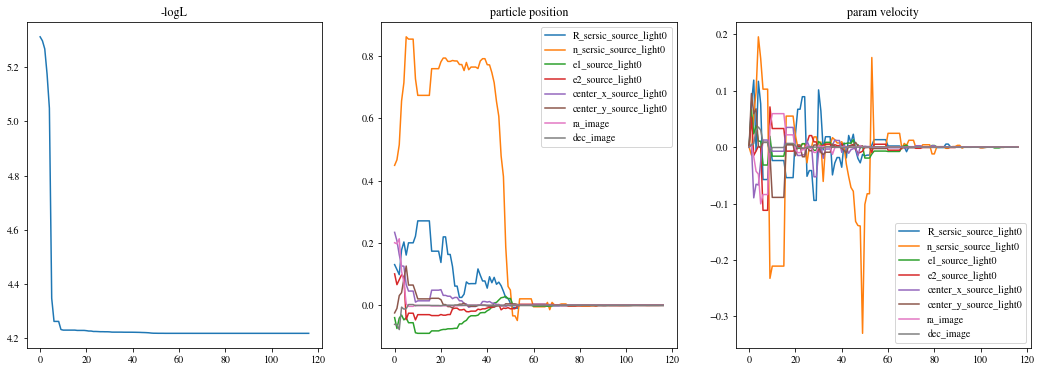

<Figure size 432x288 with 0 Axes>

/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:84: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:503: RuntimeWarning: invalid value encountered in log10
  to_show = np.log10((self._data - model)* (self._norm_residuals != 0) )
/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:503: RuntimeWarning: invalid value encountered in log10
  to_show = np.log10((self._data - model)* (self._norm_residuals != 0) )
/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:503: RuntimeWarning: invalid value encountered in log10
  to_show = np.log10((self._data - model)* (self._norm_residuals != 0) )


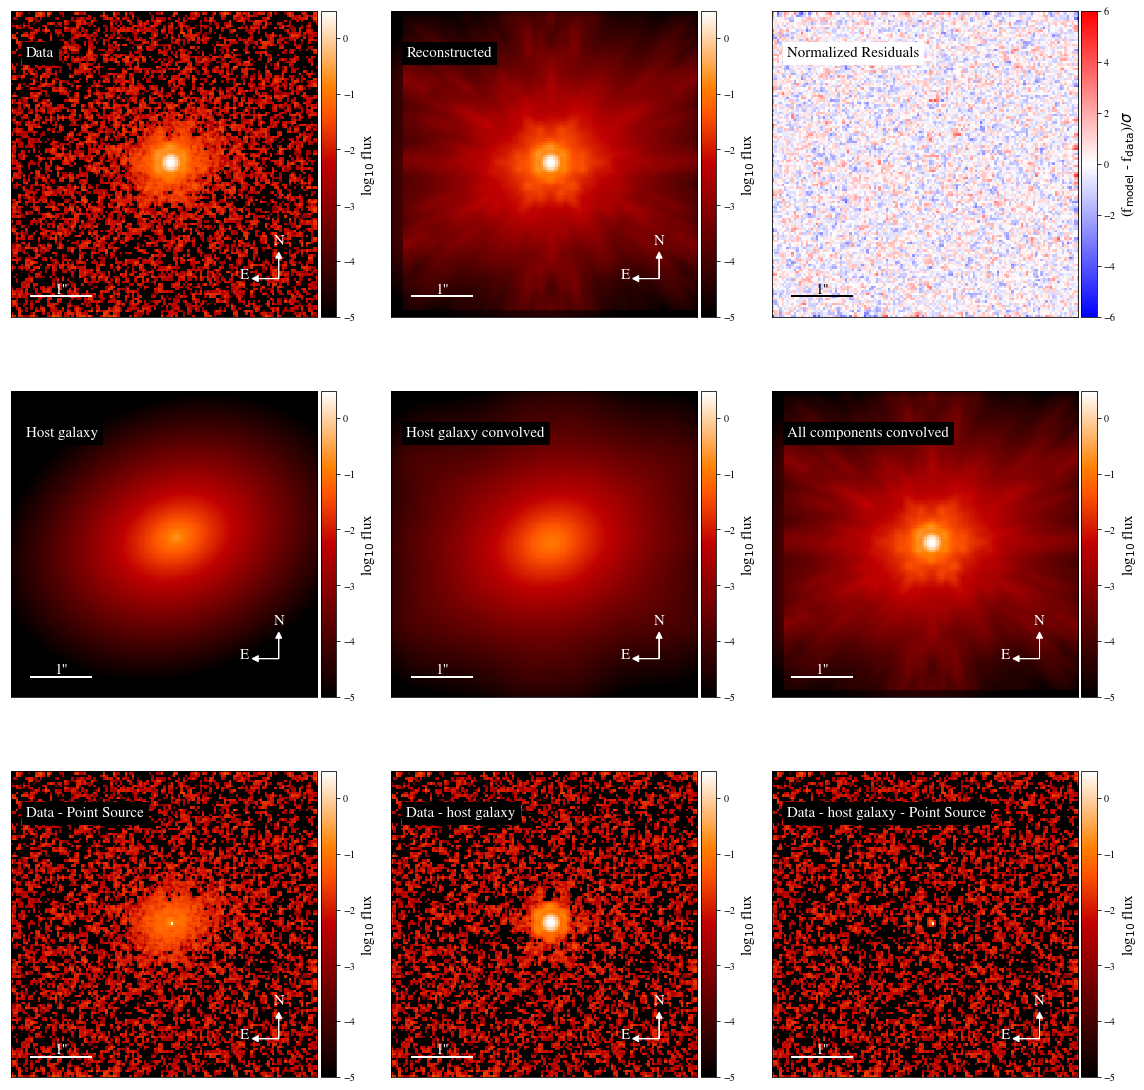

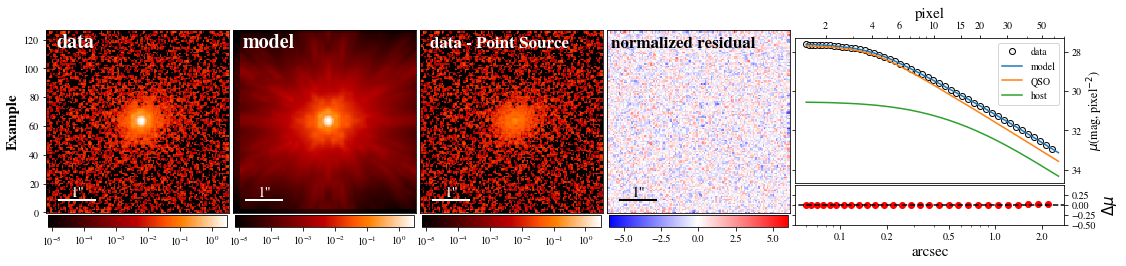

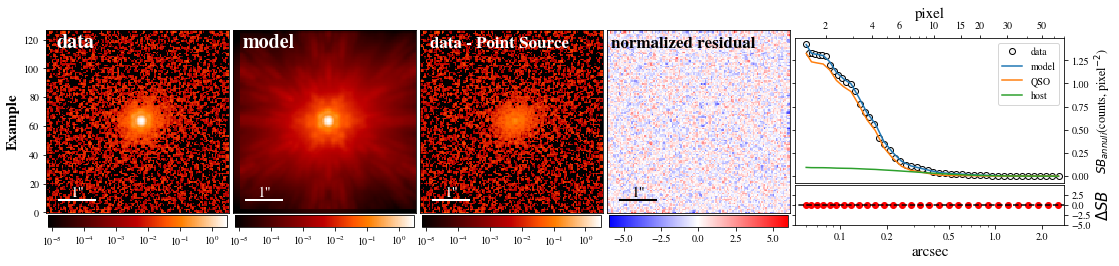

In [3]:
# input the objects components and parameteres
#objs, Q_index = detect_obj(QSO_img,pltshow = pltshow)
#qso_info = objs[Q_index]
#obj = [objs[i] for i in range(len(objs)) if i != Q_index]
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []
fixed_source.append({})  
kwargs_source_init.append({'R_sersic': 0.3, 'n_sersic': 2., 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.1, 'n_sersic': 0.3, 'center_x': -0.5, 'center_y': -0.5})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 3., 'n_sersic': 7., 'center_x': 0.5, 'center_y': 0.5})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

#tag = 'example'
source_result, ps_result, image_ps, image_host, error_map=fit_qso(QSO_img, psf_ave=psf, psf_std = None,
                                                                  source_params=source_params, fixcenter=fixcenter,
                                                                  pix_sz = pix_scale, no_MCMC = (run_MCMC==False),
                                                                  QSO_std =QSO_std, tag=None, deep_seed= deep_seed, pltshow=pltshow,
                                                                  corner_plot=False, flux_ratio_plot=True, dump_result=run_MCMC, pso_diag =True)


plot_compare=True
fits_plot =True

result = transfer_to_result(data=QSO_img, pix_sz = pix_scale,
                            source_result=source_result, ps_result=ps_result, image_ps=image_ps, image_host=image_host, error_map=error_map,
                            zp=zp, fixcenter=fixcenter,ID='Example', tag=None, plot_compare = plot_compare)


In [5]:
print("The truth:")
with open("sim_ID_0/sim_info.txt") as f: # The with keyword automatically closes the file when you are done
    print(f.read())
                     
print("The inferred results:")                     
print("host_flux:",  result['host_amp'])
print("host Reff:",  result['R_sersic'])
print("host n:",  result['n_sersic'])
print("host q:",  result['q'])
print("AGN flux :",  result['QSO_amp'])

The truth:
Filter:	F444W
Assumed exposure per frame:	625.0 (s)
oversample:	4
z_s:	6.0
host position (x, y):	(0.11114, 0.02521) arcsec
host_mag (within frame): 23.797
host_flux (within frame):	47.995
host (phi, q):	(3.424, 0.741) arcsec
host_n:	2.5
host_Reff_kpc:	2.0
host_Reff:	0.35016 arcsec
AGN_flux:	69.0342763630113
AGN position (x, y):	(0.11114, 0.02521) arcsec

The inferred results:
host_flux: 37.928
host Reff: 0.456
host n: 1.194
host q: 0.754
AGN flux : 76.164
